# MadMiner particle physics tutorial

# Part 4a: Limit setting

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 4a of this tutorial we will use the networks trained in step 3a and 3b to calculate the expected limits on our theory parameters.

## 0. Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import six
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.limits import AsymptoticLimits
from madminer.sampling import SampleAugmenter
from madminer import sampling


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        print("Deactivating logging output for", key)
        logging.getLogger(key).setLevel(logging.WARNING)

Deactivating logging output for concurrent.futures
Deactivating logging output for concurrent
Deactivating logging output for asyncio
Deactivating logging output for prompt_toolkit
Deactivating logging output for parso.python.diff
Deactivating logging output for parso.python
Deactivating logging output for parso
Deactivating logging output for parso.cache
Deactivating logging output for tornado.access
Deactivating logging output for tornado
Deactivating logging output for tornado.application
Deactivating logging output for tornado.general
Deactivating logging output for IPKernelApp
Deactivating logging output for matplotlib
Deactivating logging output for matplotlib.ticker
Deactivating logging output for matplotlib.font_manager
Deactivating logging output for matplotlib.dviread
Deactivating logging output for matplotlib.text
Deactivating logging output for matplotlib.texmanager
Deactivating logging output for matplotlib.blocking_input
Deactivating logging output for matplotlib._layoutb

## 1. Preparations

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [3]:
limits = AsymptoticLimits('data/lhe_data_shuffled.h5')
# limits = AsymptoticLimits('data/delphes_data_shuffled.h5')

09:17 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
09:17 madminer.analysis    INFO    Found 2 parameters
09:17 madminer.analysis    INFO    Did not find nuisance parameters
09:17 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
09:17 madminer.analysis    INFO    Found 3 observables
09:17 madminer.analysis    INFO    Found 15030 events
09:17 madminer.analysis    INFO      10041 generated from sm
09:17 madminer.analysis    INFO      1023 generated from w
09:17 madminer.analysis    INFO      1127 generated from neg_w
09:17 madminer.analysis    INFO      1450 generated from ww
09:17 madminer.analysis    INFO      1389 generated from neg_ww
09:17 madminer.analysis    INFO    Found morphing setup with 6 components
09:17 madminer.analysis    INFO    Did not find nuisance morphing setup


This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

First we have to define the parameter grid on which we evaluate the p-values.

In [4]:
theta_ranges = [(-20., 20.), (-20., 20.)]
resolutions = [25, 25]

What luminosity (in inverse pb) are we talking about?

In [5]:
lumi = 10000.

In [6]:
p_values = {}
mle = {}

## 2. Expected limits based on histogram

First, as a baseline, let us calculate the expected limits based on a simple jet pT histogram. Right now, there are not a lot of option for this function; MadMiner even calculates the binning automatically. (We will add more functionality!)

The keyword `include_xsec` determines whether we include information from the total rate or just use the shapes. Since we don't model backgrounds and systematics in this tutorial, the rate information is unrealistically large, so we leave it out here.

In [7]:
_, p_values_expected_histo, best_fit_expected_histo = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["Histogram"] = p_values_expected_histo
mle["Histogram"] = best_fit_expected_histo

09:17 madminer.limits      INFO    Generating Asimov data
09:17 madminer.limits      INFO    Expected events: 2.0624823097636553
09:17 madminer.limits      DEBUG   Calculating p-values for 2.0624823097636553 expected events
09:17 madminer.limits      INFO    Setting up standard summary statistics
09:17 madminer.limits      DEBUG   Using x indices [0]
09:17 madminer.limits      DEBUG   Preparing observables [0] as summary statistic function
09:17 madminer.limits      INFO    Creating histogram with 20 bins for the summary statistics
09:17 madminer.limits      INFO    Building histogram with [25, 25] bins per parameter and 20 bins per observable
09:17 madminer.limits      DEBUG   Generating histo data
09:17 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
09:17 madminer.analysis    INFO    Found 2 parameters
09:17 madminer.analysis    INFO    Did not find nuisance parameters
09:17 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
09:17 madminer.

09:20 madminer.limits      DEBUG   Min-subtracted -2 log r: [ 4.21999661  4.1905249   4.20156878  4.17422778  4.27401197  4.32740643
  4.27196228  4.31492902  4.38453979  4.37925771  4.37249336  4.40444196
  4.32724404  4.34672733  4.29087017  4.29070225  4.26180496  4.24292203
  4.19968673  4.15006127  4.10726004  4.07928107  3.9973639   4.0230279
  4.03718942  4.10964751  4.1634733   4.13617304  4.15738114  4.16675638
  4.19401653  4.22155777  4.30141416  4.27785794  4.29360148  4.22328892
  4.18922959  4.26325842  4.23123528  4.19849888  4.18396649  4.08085016
  4.08432204  4.10978368  4.08448551  4.01521772  3.97061768  4.01361487
  3.93465147  3.96520632  4.04855513  4.08745189  4.07058958  4.1032144
  4.1134364   4.10472952  4.06818731  4.19058871  4.13842302  4.16165128
  4.17749886  4.14010902  4.13933589  4.09514418  4.07849314  4.07997244
  4.0127175   4.01281504  3.96209828  3.96344429  3.97072899  3.93318359
  3.91881723  3.85944114  3.89266537  4.05153247  3.99831593  4.00

With `mode="rate"`, we could calculate limits based on only the rate -- but again, since the rate is extremely powerful when backgrounds and systematics are not taken into account, we don't do that in this tutorial.

## 3. Expected limits based on ratio estimators

Next, `mode="ml"` allows us to calculate limits based on any `ParamterizedRatioEstimator` instance like the ALICES estimator trained above:

In [8]:
theta_grid, p_values_expected_alices, best_fit_expected_alices = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES"] = p_values_expected_alices
mle["ALICES"] = best_fit_expected_alices

09:20 madminer.limits      INFO    Generating Asimov data
09:20 madminer.limits      INFO    Expected events: 2.0624823097636553
09:20 madminer.limits      DEBUG   Calculating p-values for 2.0624823097636553 expected events
09:20 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
09:20 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
09:25 madminer.limits      DEBUG   Raw mean -2 log r: [-0.29168691  0.03095453  0.37584456  0.71478857  0.90538831  0.8715453
  0.72229303  0.66092503  0.71790528  0.7622584   0.73800932  0.65993557
  0.54237242  0.58311412  0.81258973  0.9881112   1.03000813  1.00977047
  0.99566558  1.00777385  1.04164913  1.09311291  1.14332579  1.15409538
  1.09708445 -0.38487775 -0.08079408  0.24449116  0.5739736   0.8614091
  0.96228622  0.8517799   0.71396379  0.71171505  0.76933808  0.76846764
  0.69000267  0.56081208  0.59754831  0.81171198  0.96135058  0.97946125
  0.94932649  0.93682992  0.95355489  0.

09:25 madminer.limits      INFO    Calculating p-values
09:25 madminer.limits      DEBUG   Combined -2 log r: [3.00197864 3.78301227 4.56349347 5.30427753 5.69656995 5.56902032
 5.21904148 5.08651895 5.20117433 5.28580449 5.21386799 5.00450458
 4.66913211 4.69970506 5.1862695  5.56454982 5.62683926 5.53889115
 5.47407578 5.49648783 5.58765385 5.70976269 5.80714072 5.7831825
 5.56829857 2.74136261 3.50276051 4.28539434 5.02681757 5.64507889
 5.82171706 5.52440651 5.2076525  5.19436468 5.30721406 5.28642177
 5.07312334 4.70773674 4.72705738 5.17190759 5.48400689 5.48870593
 5.38132076 5.33217077 5.37748816 5.47309408 5.55428221 5.53439483
 5.33756327 5.02787551 2.78862848 3.23714492 3.99138099 4.75692223
 5.42863809 5.87659354 5.81774962 5.42385286 5.21636814 5.2839557
 5.30932683 5.10179306 4.70513173 4.70236106 5.09110506 5.33113412
 5.29110335 5.18740115 5.16750693 5.22589385 5.28622447 5.26293194
 5.08716773 4.81867078 4.60257137 2.9798861  3.29659815 3.73030145
 4.45367758 5.1753253

## 4. Expected limits based on score estimators

To get p-values from a SALLY estimator, we have to use histograms of the estimated score:

In [9]:
theta_grid, p_values_expected_sally, best_fit_expected_sally = limits.expected_limits(
    mode="histo",
    model_file='models/sally',
    theta_true=[0.,0.],
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["SALLY"] = p_values_expected_sally
mle["SALLY"] = best_fit_expected_sally

09:25 madminer.limits      INFO    Generating Asimov data
09:25 madminer.limits      INFO    Expected events: 2.0624823097636553
09:25 madminer.limits      DEBUG   Calculating p-values for 2.0624823097636553 expected events
09:25 madminer.limits      INFO    Loading score estimator and setting it up as summary statistics
09:25 madminer.limits      DEBUG   Preparing score estimator as summary statistic function
09:25 madminer.limits      INFO    Creating histogram with 20 bins for the summary statistics
09:25 madminer.limits      INFO    Building histogram with [25, 25] bins per parameter and 20 bins per observable
09:25 madminer.limits      DEBUG   Generating histo data
09:25 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
09:25 madminer.analysis    INFO    Found 2 parameters
09:25 madminer.analysis    INFO    Did not find nuisance parameters
09:25 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
09:25 madminer.analysis    INFO    Found 3 ob

09:33 madminer.limits      DEBUG   Min-subtracted -2 log r: [ 5.99228819  6.09556033  6.18826664  6.27556124  6.44384104  6.56715935
  6.63152069  6.59201059  6.47247927  6.44412184  6.26445061  6.35300076
  6.21488688  6.24194464  6.32077423  6.42047264  6.34202572  6.33072011
  6.2627028   6.19828136  6.10558562  5.98305878  5.86097132  5.65032646
  5.59196618  5.84637104  5.90803483  6.06849632  6.09636116  6.19785295
  6.48772753  6.43597833  6.42360421  6.39500158  6.3254449   6.16049201
  6.05855983  6.04834545  6.04134814  6.01534659  6.07897941  6.22762806
  6.08129757  6.13313403  6.0992231   5.90612742  5.81059046  5.71407551
  5.49093858  5.53086301  5.62701987  5.87171497  5.96352688  6.03419197
  6.08261739  6.17983774  6.28719934  6.35183853  6.35143217  6.05685157
  6.05020754  5.96065983  5.84621647  5.75577182  5.85112385  5.93844236
  6.01320425  5.89884454  5.93955026  5.86016733  5.73998727  5.65827581
  5.53904185  5.38778472  5.25095228  5.57874087  5.63118472  5.

## 5. Toy signal

In addition to these expected limits (based on the SM), let us inject a mock signal. We first generate the data:

In [10]:
sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
x_observed, _, _ = sampler.sample_test(
    theta=sampling.morphing_point([10.,10.]),
    n_samples=100,
    folder=None,
    filename=None,
)

09:33 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
09:33 madminer.analysis    INFO    Found 2 parameters
09:33 madminer.analysis    INFO    Did not find nuisance parameters
09:33 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
09:33 madminer.analysis    INFO    Found 3 observables
09:33 madminer.analysis    INFO    Found 15030 events
09:33 madminer.analysis    INFO      10041 generated from sm
09:33 madminer.analysis    INFO      1023 generated from w
09:33 madminer.analysis    INFO      1127 generated from neg_w
09:33 madminer.analysis    INFO      1450 generated from ww
09:33 madminer.analysis    INFO      1389 generated from neg_ww
09:33 madminer.analysis    INFO    Found morphing setup with 6 components
09:33 madminer.analysis    INFO    Did not find nuisance morphing setup
09:33 madminer.sampling    INFO    Extracting evaluation sample. Sampling according to [10. 10.]
09:33 madminer.sampling    INFO    Starting sampling serially
09:

In [11]:
_, p_values_observed, best_fit_observed = limits.observed_limits(
    x_observed=x_observed,
    mode="ml",
    model_file='models/alices',
    theta_ranges=theta_ranges,
    resolutions=resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES signal"] = p_values_observed
mle["ALICES signal"] = best_fit_observed

09:33 madminer.limits      DEBUG   Calculating p-values for 100 expected events
09:33 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
09:33 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
09:33 madminer.limits      DEBUG   Raw mean -2 log r: [-3.90905842 -3.71976981 -3.46083001 -3.18133235 -3.00723323 -3.00128215
 -3.1195541  -3.17348622 -3.11085613 -3.06523908 -3.06750731 -3.08093946
 -3.07718863 -2.94254187 -2.68125311 -2.49363711 -2.41699112 -2.39733582
 -2.39551558 -2.39972071 -2.39009584 -2.34282669 -2.2687145  -2.20541388
 -2.18002884 -3.92850711 -3.77759759 -3.58369169 -3.33256266 -3.08648746
 -2.97129498 -3.02932882 -3.13741388 -3.12625783 -3.06110103 -3.04350719
 -3.05755903 -3.06139967 -2.92850337 -2.67532715 -2.50625317 -2.44942888
 -2.44177221 -2.44603673 -2.44674148 -2.42028821 -2.36248248 -2.3062349
 -2.28791628 -2.31032181 -3.868359   -3.80022531 -3.64106848 -3.44664865
 -3.21185257 -3.01022232 -2.96404307 

09:33 madminer.limits      INFO    Calculating p-values
09:33 madminer.limits      DEBUG   Combined -2 log r: [-390.90584207 -371.97698081 -346.08300066 -318.13323492 -300.72332299
 -300.1282146  -311.95540971 -317.34862226 -311.08561325 -306.52390823
 -306.75073117 -308.09394568 -307.71886295 -294.25418669 -268.12531066
 -249.36371088 -241.6991117  -239.73358172 -239.5515582  -239.97207129
 -239.00958425 -234.28266943 -226.87145013 -220.54138827 -218.00288373
 -392.85071069 -377.75975871 -358.36916852 -333.25626552 -308.64874583
 -297.12949771 -302.93288171 -313.7413885  -312.62578261 -306.11010268
 -304.35071909 -305.75590301 -306.13996702 -292.85033661 -267.53271502
 -250.6253165  -244.94288826 -244.17722142 -244.60367316 -244.6741482
 -242.02882093 -236.24824792 -230.62349045 -228.79162794 -231.0321812
 -386.83589965 -380.02253121 -364.10684842 -344.66486526 -321.1852572
 -301.02223182 -296.40430659 -306.49240929 -312.2033093  -306.86593235
 -302.7584095  -303.91487104 -305.2075941

09:33 madminer.limits      DEBUG   Min-subtracted -2 log r: [  3.85627496  22.78513622  48.67911637  76.62888211  94.03879404
  94.63390243  82.80670732  77.41349477  83.67650378  88.2382088
  88.01138586  86.66817135  87.04325408 100.50793034 126.63680637
 145.39840615 153.06300533 155.02853531 155.21055883 154.79004574
 155.75253278 160.4794476  167.8906669  174.22072875 176.7592333
   1.91140634  17.00235832  36.39294851  61.50585151  86.11337119
  97.63261932  91.82923532  81.02072853  82.13633442  88.65201434
  90.41139793  89.00621402  88.62215    101.91178042 127.22940201
 144.13680053 149.81922877 150.58489561 150.15844387 150.08796883
 152.7332961  158.51386911 164.13862658 165.97048908 163.72993582
   7.92621738  14.73958582  30.65526861  50.09725177  73.57685983
  93.73988521  98.35781044  88.26970774  82.55880773  87.89618468
  92.00370753  90.84724599  89.55452287 102.11583382 125.8467049
 140.65855742 144.95280308 145.26686209 144.96702284 146.10831326
 150.05377853 154.6

## 6. Plot

Let's plot the results:

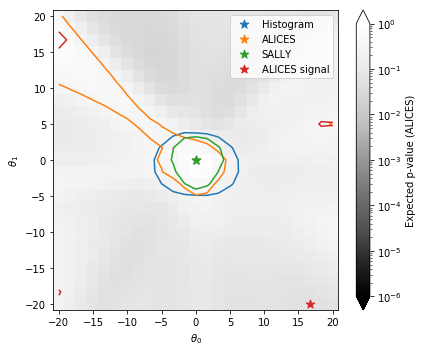

In [15]:
show = "ALICES"

bin_size = (theta_ranges[0][1] - theta_ranges[0][0])/(resolutions[0] - 1)
edges = np.linspace(theta_ranges[0][0] - bin_size/2, theta_ranges[0][1] + bin_size/2, resolutions[0] + 1)
centers = np.linspace(theta_ranges[0][0], theta_ranges[0][1], resolutions[0])

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cmin, cmax = 1.e-6, 1.

pcm = ax.pcolormesh(
    edges, edges, p_values[show].reshape((resolutions[0], resolutions[1])),
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='Greys_r'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    plt.contour(
        centers, centers, p_value.reshape((resolutions[0], resolutions[1])),
        levels=[0.32],
        linestyles='-', colors='C{}'.format(i)
    )
    plt.scatter(
        theta_grid[mle[label]][0], theta_grid[mle[label]][1],
        s=80., color='C{}'.format(i), marker='*',
        label=label
    )

plt.legend()

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Expected p-value ({})'.format(show))

plt.tight_layout()
plt.show()
